# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, I built a Traffic Sign Recognition Classifier based off of the LeNet 5 Convolutional Neural Net architecture.   

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.


---
## Load The Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    validation = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = validation['features'], validation['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import pandas

### Use python, pandas or numpy methods rather than hard coding the results

#Number of training examples
n_train = len(X_train)

#Number of validation examples
n_validation = len(X_validation)

#Number of testing examples.
n_test = len(X_test)

image_shape = np.shape(X_train[1])

#How many unique classes/labels there are in the dataset.
n_classes = len(pd.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the dataset

In [4]:
# get a dictionary whose keys are the sign id's and whose values are the sign names (from Jeff L Iron Github)

with open('signnames.csv', 'r') as signnames:
    sign_names_dict = dict(line.strip().split(',') for line in signnames.readlines()[1:])
    
# get a list `signs_by_id_*` where `signs_by_id_*[i]` is a list of all signs with id `i` in set *
signs_by_id_train = [[ind for ind, sign_id in enumerate(y_train) if sign_id == i] for i in range(n_classes)]
signs_by_id_validation = [[ind for ind, sign_id in enumerate(y_validation) if sign_id == i] for i in range(n_classes)]
signs_by_id_test = [[ind for ind, sign_id in enumerate(y_test) if sign_id == i] for i in range(n_classes)]

# get a list `sign_examples` where `sign_examples[i]` is an example of sign type `i`
sign_examples = [None] * n_classes
for i in range(n_classes):
    j = 0
    while np.mean(X_train[signs_by_id_train[i][j], :, :, :]) < 64. and j < len(signs_by_id_train[i]) - 1:
        j += 1
    sign_examples[i] = X_train[signs_by_id_train[i][j], :, :, :]

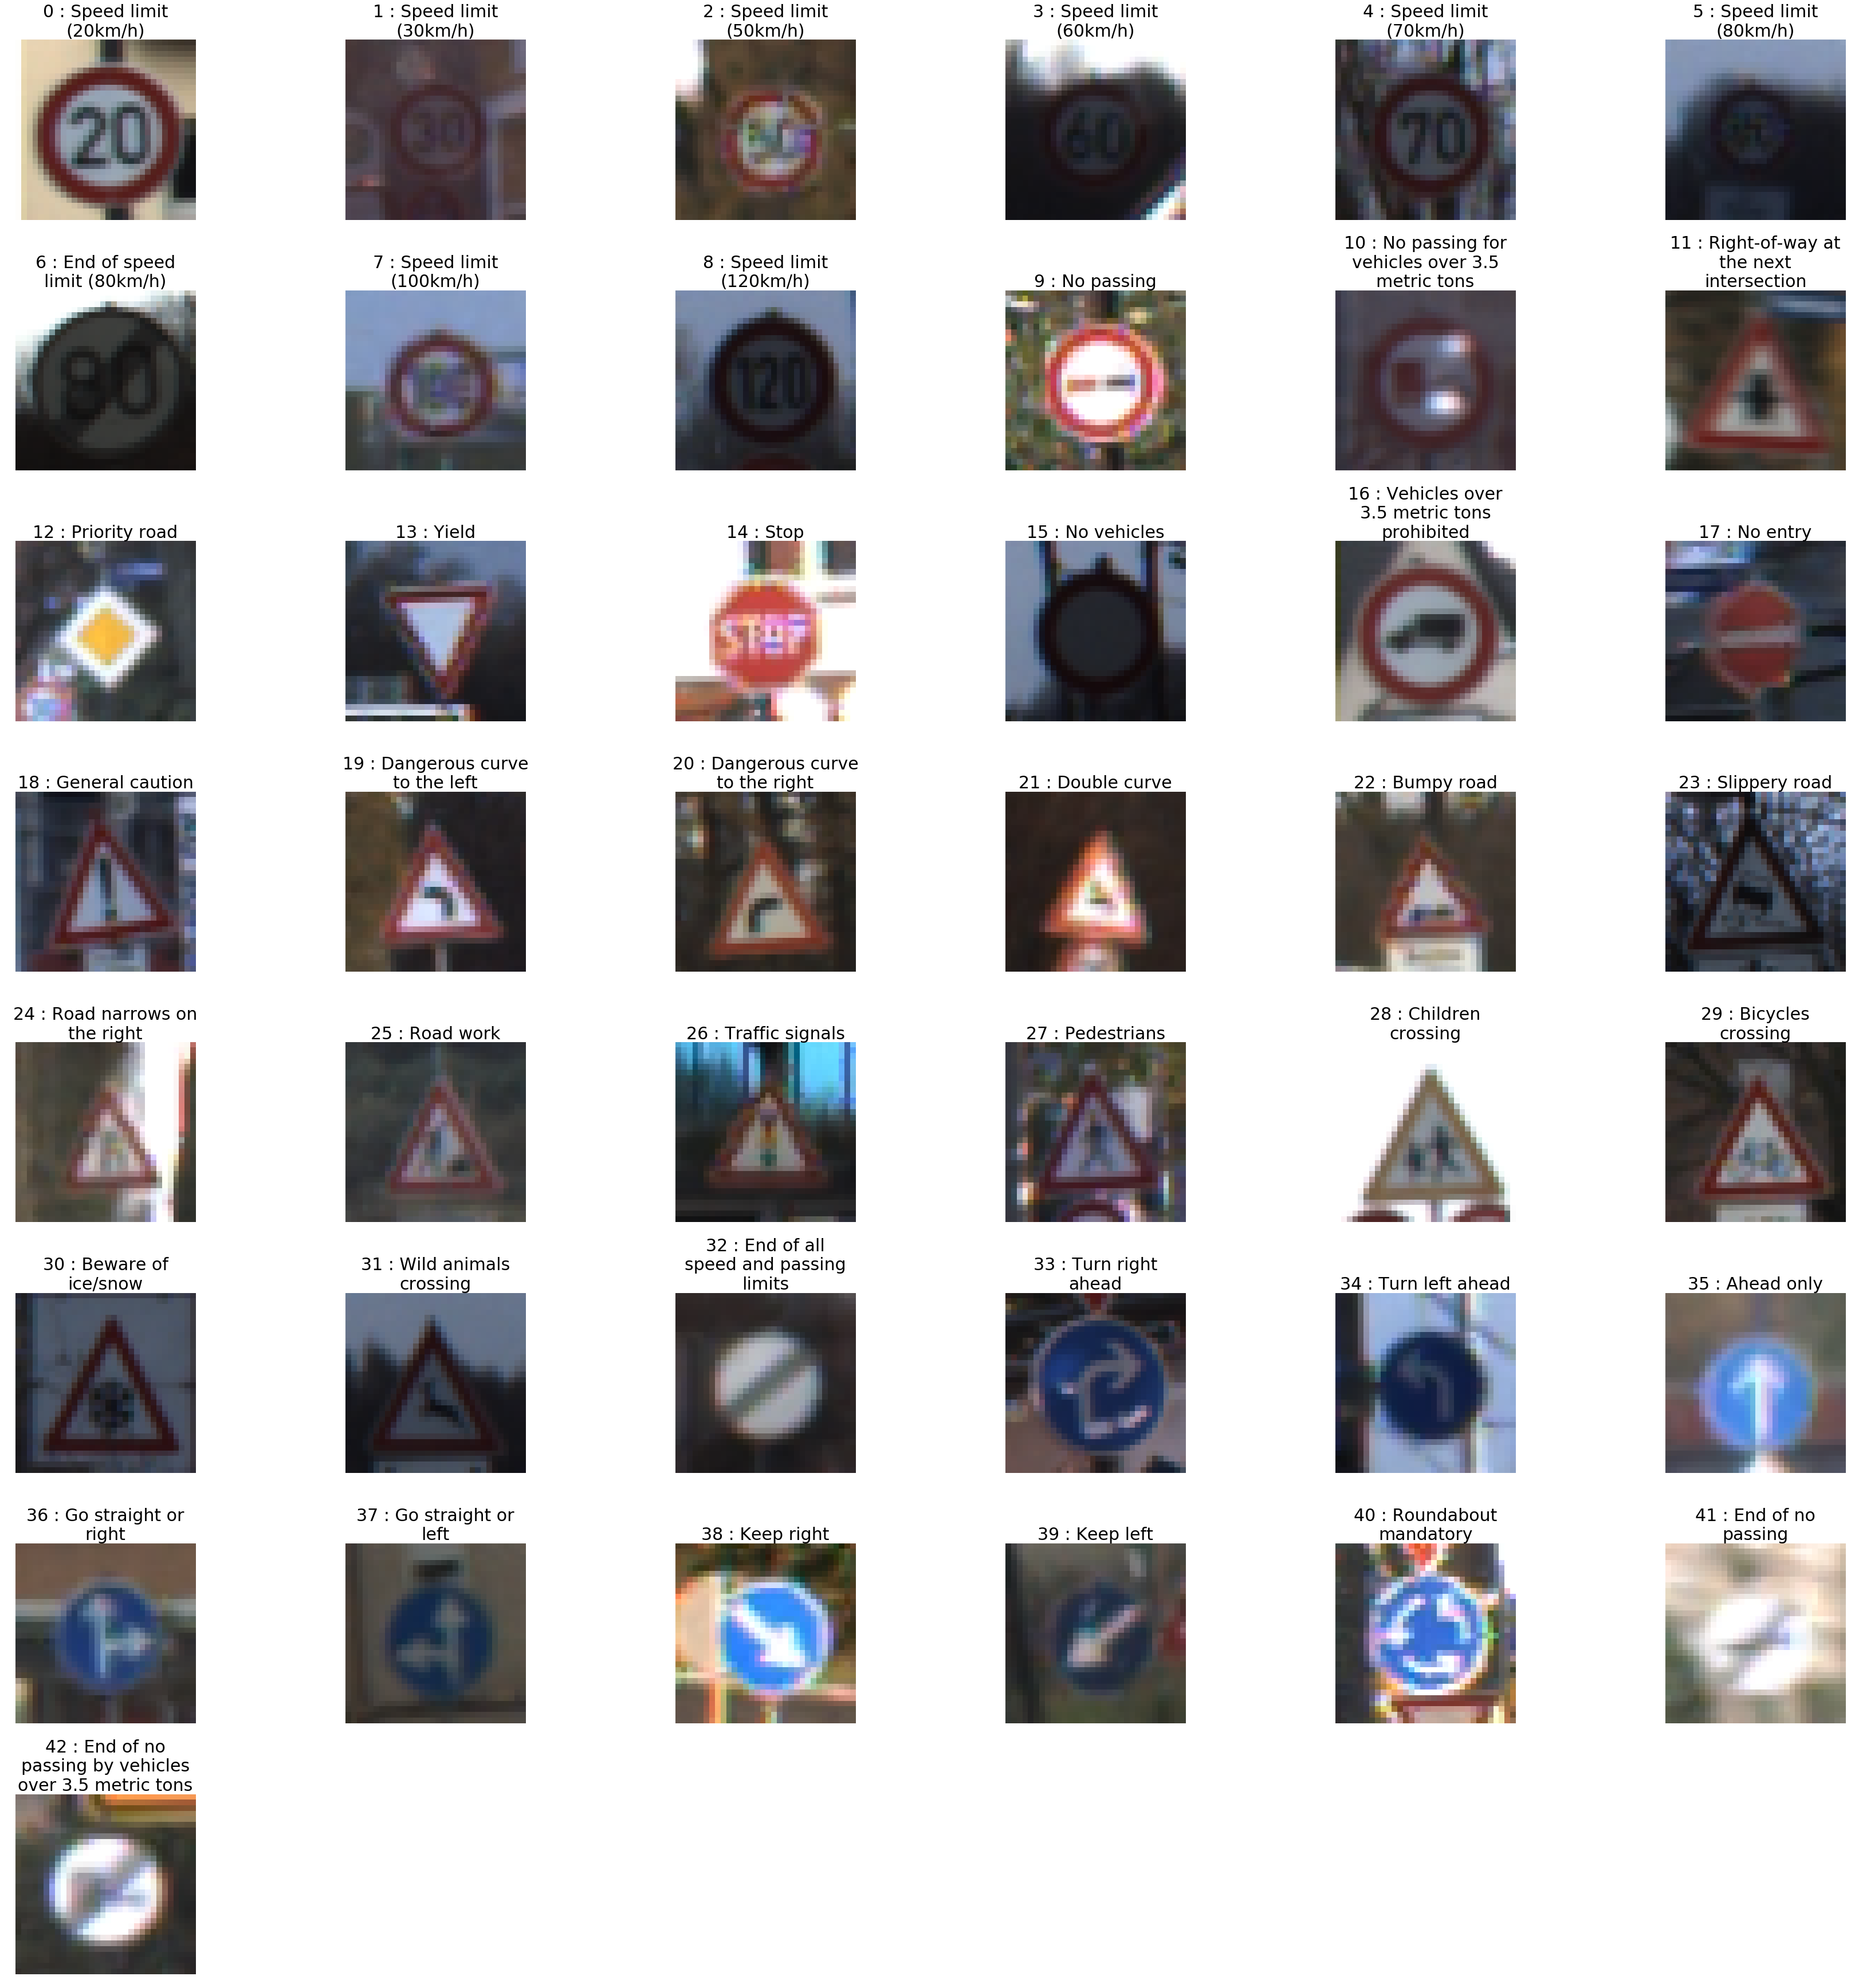

In [5]:
from textwrap import wrap
import matplotlib.pyplot as plt
# plot an example of each sign type

plt.figure(1, figsize=(48,48))
for i in range(43):

    plt.subplot(8, 6, i+1)
    plt.title("\n".join(wrap('{0} : {1}'.format(i, sign_names_dict[str(i)]), 20)), fontsize=30)
    plt.imshow(sign_examples[i])
    plt.axis('off')

plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)
plt.show()

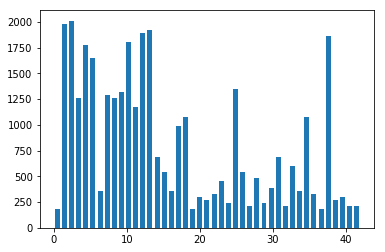

In [6]:
# histogram of label frequency

hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

----

## Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

I normalized the image data so that the data has mean zero and equal variance. For image data, I used `(pixel - 128)/ 128` .  I also experimented with using grayscale images.  Ultimately I was able to reach the target accuracy levels within using grayscale.


In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
def normalize_image(img):
    return (img - 128.) / 128.

def rgb2gray(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def preprocess(img):
    #img = rgb2gray(img)
    img = normalize_image(img)
    return img

In [8]:
X_train = np.array([preprocess(img) for img in X_train])
X_validation = np.array([preprocess(img) for img in X_validation])
X_test = np.array([preprocess(img) for img in X_test])

### Model Architecture

The submission provides details of the characteristics and qualities of the architecture, including the type of model used, the number of layers, and the size of each layer. Visualizations emphasizing particular qualities of the architecture are encouraged.

#### Input
The architecture accepts a 32x32xC image as input, where C is the number of color channels. 

#### Architecture
Layer 1: Convolutional. The output shape should be 28x28x6.<br>
Activation: ReLU. <br>
Pooling: The output shape should be 14x14x6.<br>
Layer 2: Convolutional. The output shape should be 10x10x16.<br>
Activation: ReLU.<br>
Pooling: The output shape should be 5x5x16.<br>
Flatten: Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.<br>
Layer 3: Fully Connected, 120 outputs.<br>
Activation: ReLU with dropout.<br>
Layer 4: Fully Connected, 84 outputs.<br>
Activation: ReLU with dropout.<br>
Layer 5: Fully Connected (Logits) with 43 outputs.<br>

#### Output
Return the result of the 2nd fully connected layer.

#### Hyperparameters


In [9]:
EPOCHS = 20
BATCH_SIZE = 128
rate = 0.001

In [10]:
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.dropout(tf.nn.relu(fc1), keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    #fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(tf.nn.relu(fc2), keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

Features and Labels
Train LeNet to classify data.
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

Training Pipeline

In [12]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.
You do not need to modify this section.

In [24]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        print(accuracy)
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Train the Model
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the loss and accuracy of the validation set.
Save the model after training.
You do not need to modify this section.

In [14]:
save_file = './train_model.ckpt'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.1f}%".format(validation_accuracy*100))
        print()
        
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 69.1%

EPOCH 2 ...
Validation Accuracy = 82.7%

EPOCH 3 ...
Validation Accuracy = 87.2%

EPOCH 4 ...
Validation Accuracy = 90.8%

EPOCH 5 ...
Validation Accuracy = 91.7%

EPOCH 6 ...
Validation Accuracy = 92.4%

EPOCH 7 ...
Validation Accuracy = 93.9%

EPOCH 8 ...
Validation Accuracy = 93.6%

EPOCH 9 ...
Validation Accuracy = 94.8%

EPOCH 10 ...
Validation Accuracy = 94.2%

EPOCH 11 ...
Validation Accuracy = 94.2%

EPOCH 12 ...
Validation Accuracy = 94.6%

EPOCH 13 ...
Validation Accuracy = 95.4%

EPOCH 14 ...
Validation Accuracy = 95.1%

EPOCH 15 ...
Validation Accuracy = 95.4%

EPOCH 16 ...
Validation Accuracy = 95.6%

EPOCH 17 ...
Validation Accuracy = 95.8%

EPOCH 18 ...
Validation Accuracy = 95.7%

EPOCH 19 ...
Validation Accuracy = 95.8%

EPOCH 20 ...
Validation Accuracy = 95.7%

Model saved


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:

with tf.Session() as sess:
    saver.restore(sess, save_file)
    
    training_acc = evaluate(X_train, y_train)*100
    validation_acc = evaluate(X_validation, y_validation)*100
    test_acc = evaluate(X_test, y_test)*100

    print("\n")
    print("  Training set accuracy = {:.1f}%".format(training_acc))
    print("Validation set accuracy = {:.1f}%".format(validation_acc))
    print("      Test set accuracy = {:.1f}%".format(test_acc))

INFO:tensorflow:Restoring parameters from ./train_model.ckpt


  Training set accuracy = 99.7%
Validation set accuracy = 95.7%
      Test set accuracy = 93.8%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

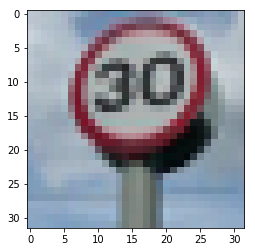

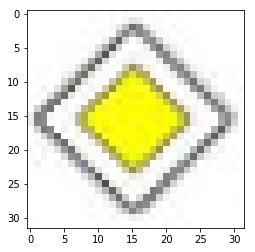

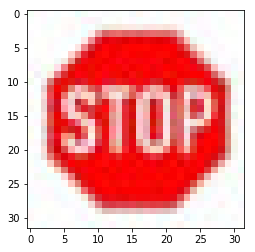

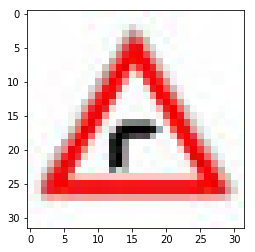

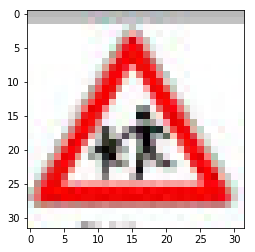

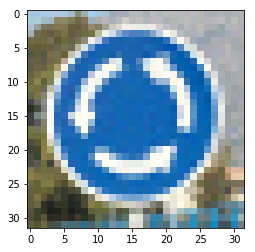

In [43]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg

test_signs_dir = 'test_signs/'

sign_pics = os.listdir(test_signs_dir)

# Show the images, add to a list to process for classifying
sign_list = []
for i in sign_pics:
    image = mpimg.imread(test_signs_dir + i)
    sign_list.append(image)
    plt.imshow(image)
    plt.show()


### Predict the Sign Type for Each Image

In [44]:
correct_labels = [1,12,14,20,28,40] 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_file)
    my_accuracy = evaluate(sign_list, correct_labels)*100
    print("Test Set Accuracy = {:.1f}%".format(my_accuracy))


INFO:tensorflow:Restoring parameters from ./train_model.ckpt
0.833333
Test Set Accuracy = 83.3%


### Analyze Performance

In [45]:
sign_list = np.array(sign_list)
sign_list = preprocess(sign_list)

In [47]:
prediction = tf.argmax(logits, 1 )

with tf.Session() as sess:
    saver.restore(sess, save_file)
    online_signs = sess.run(prediction, feed_dict={x: sign_list, keep_prob : 1.0})
    predictions = sess.run(tf.nn.top_k(online_signs, k=6, sorted=True))


print(predictions)
for i in range(len(predictions[0])):
    #print('Image', i, 'prediction:', predictions[0][i], '\n and predicted classes:', predictions[1][i])
    print('Image', predictions[1][i], 'prediction:',"Sign",predictions[0][i])
    

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
TopKV2(values=array([40, 28, 20, 14, 13, 12], dtype=int64), indices=array([5, 4, 3, 2, 0, 1]))
Image 5 prediction: Sign 40
Image 4 prediction: Sign 28
Image 3 prediction: Sign 20
Image 2 prediction: Sign 14
Image 0 prediction: Sign 13
Image 1 prediction: Sign 12


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 


In [42]:
#softmax_logits = tf.nn.softmax(logits)

top_k = tf.nn.top_k(tf.nn.softmax(logits),6)

with tf.Session() as sess:
    saver.restore(sess, save_file)
    #my_softmax_logits = sess.run(softmax_logits, feed_dict={x: sign_list, keep_prob: 1.0})
    #signs_softmax = sess.run(tf.nn.softmax(my_softmax_logits))
    #predictions = sess.run(tf.nn.top_k(signs_softmax, k=5, sorted=True))
    
    predictions = sess.run(top_k, feed_dict={
        x: sign_list, 
        keep_prob: 1.0})

#print("predictions",predictions)
for i in range(len(predictions[0])):
    print('Image', i, 'prediction:', predictions[0][i], '\n and predicted classes:', predictions[1][i])

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 0 prediction: [  1.00000000e+00   4.34469364e-24   6.31696445e-30   6.84808308e-31
   1.93900262e-31   1.53823686e-31] 
 and predicted classes: [12 26 13 10 42 14]
Image 1 prediction: [  9.99976039e-01   1.95864486e-05   3.97229360e-06   4.29761599e-07
   9.98903076e-08   1.30944127e-08] 
 and predicted classes: [14 29 25  3  1 17]
Image 2 prediction: [ 0.48172793  0.37082523  0.13879798  0.00405282  0.00224047  0.00081055] 
 and predicted classes: [13  9 34 38 39 17]
Image 3 prediction: [  1.00000000e+00   5.33173956e-11   4.99870770e-17   3.05846606e-20
   4.78486180e-21   3.42575880e-23] 
 and predicted classes: [20 28 23 41 29 25]
Image 4 prediction: [  1.00000000e+00   7.51234275e-09   4.22055967e-12   2.64683078e-13
   3.07177689e-17   1.06834578e-17] 
 and predicted classes: [28 20 29 27 23 24]
Image 5 prediction: [  9.99999642e-01   3.90659068e-07   8.68589406e-16   8.53769589e-18
   4.24553164e-19   2.35924625e

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [21]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")